In [16]:
from pymongo import MongoClient
import os
import sys
import pandas as pd
import numpy as np
import importlib

# custom module
from utils import utilsvectorizer as uv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import stop_words


# Plotting tools
import pyLDAvis
from pyLDAvis.sklearn import prepare
from pyLDAvis.gensim import prepare as prepare_gensim

# nltk
from nltk.stem.wordnet import WordNetLemmatizer

# spacy for language processing
import spacy

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore, KeyedVectors
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

import matplotlib.pyplot as plt

### Lemmatize stopwords from sklearn
In my custom tfidf vectorizer, lemmatization is done before removing stopwords. Therefore, 'has' becomes 'ha' post lemmatization and 'has' is a stopword!

In [17]:
# sklearn english stopwords
sw_sklearn = stop_words.ENGLISH_STOP_WORDS
# lemmatization to convert plurals words to singular word
Lem = WordNetLemmatizer()
# lemmatize those and update our list
sw_sklearn = set([Lem.lemmatize(s) for s in sw_sklearn ])
# add other common
# sw = sw_sklearn.union(names_corp)
sw = sw_sklearn

In [5]:
# Create a client connection to the MongoDb instance running on the local machine
client = MongoClient('localhost:27017')

In [6]:
# connect to database of interest
db = client.awards_tmp

In [7]:
# cursor_tmp is a generator
cursor_tmp = db.awards_tmp.find({}, {'Amount' : 1,
                                     'amount_corrected' : 1,
                                     'Agency' : 1,
                                     'Branch' : 1,
                                     'Abstract' : 1,
                                     'company name' : 1,
                                     'DUNS' : 1,
                                     'title' : 1,
                                     'Awards Year' : 1,
                                     'Phase':1,
                                     'Contract': 1,
                                     '_id': False} )
# need a new cursor (generator) after you used it
df = pd.DataFrame(list(cursor_tmp))

In [8]:
# convert Awards year to datetime object
df['Awards Year'] = pd.to_datetime(df['Awards Year'])

In [9]:
# mark 'N/A' abstract by nan
df.loc[df.Abstract == 'N/A', 'Abstract'] = np.nan

In [10]:
# concatenate abstract and title
df['text'] = df.Abstract.add(df.title, fill_value = '')

### Add agency abbreviation

In [11]:
agency_name = {'usda' : 'Department of Agriculture',
                'doc' : 'Department of Commerce',
                'dod' : 'Department of Defense',
                'ed' : 'Department of Education',
                'doe' : 'Department of Energy',
                'hhs' : 'Department of Health and Human Services',
                'dhs' : 'Department of Homeland Security',
                'dot' : 'Department of Transportation',
                'epa' : 'Environmental Protection Agency',
                'nasa' : 'National Aeronautics and Space Administration',
                'nsf' : 'National Science Foundation'}

In [12]:
agency_map = {v: k for k, v in agency_name.items()}

In [13]:
df['agency_abbr'] = df.Agency.map(agency_map)

In [14]:
agency = df.agency_abbr.value_counts().index

In [15]:
len(agency), agency

(11,
 Index(['dod', 'hhs', 'nasa', 'nsf', 'doe', 'usda', 'epa', 'doc', 'ed', 'dot',
        'dhs'],
       dtype='object'))

### Load word2vec pre-trained model (skip-gram)

In [14]:
# print(word2vec['phase'])

### function to return an average vector

In [1]:
#apply the word2vec model to a set of words and average them. 
def evaluate_set(words):
    '''evaluate each word in '''
    n = 0
    a = []
    for w in words:
        #attempt to evaluate vectorial representation of word.
        try:
            v = word2vec[w]
            if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                a.append(v)
                n += 1
        except KeyError as e:
            pass
    #if nothing was valid, return nan
    if(n==0):
        return np.full([300,], np.nan)
    #return average
    return np.mean(np.array(a),axis=0)

## Take Phase I and One agency

In [105]:
ag = 'dod'
print('Modeling {}'.format(ag))
# discard 0 amount, N/A abstract. Agency shall not be missing and only consider Phase I
crit = (df.agency_abbr == ag) & (df.Phase == 'Phase I') & (df.amount_corrected > 0)
df_analysis = df.loc[crit,:].copy()
df_analysis.shape

Modeling hhs


(28703, 13)

In [106]:
vec = uv.CustomTfidfVectorizer(
                            stop_words = sw,
                            lowercase = True,
                            min_df = 2,)
Xdtm_tfidf = vec.fit_transform(df_analysis.text.values)
Xdtm_tfidf.shape

(28703, 38528)

In [107]:
# recover words vocabulary and convert python list to numpy array
words = vec.get_feature_names()
words_np = np.array(words)
words_np.shape, type(words_np)

((38528,), numpy.ndarray)

### Process documents

Construct list of document vectors (average of word vectors)

In [110]:
# list of vectors
allvectors = []

for h in range(Xdtm_tfidf.shape[0]):
    # select first document (X is a scipy matrix)
    X = Xdtm_tfidf[h,:]
#     X.shape, type(X)

    # select index of non-zero words
    # nonzero returns a tuple, we need 2nd element
    words_index = np.nonzero(X)[1]
#     words_index.shape, type(words_index)

    # words_np[words_index]
    thisX =  evaluate_set(words_np[words_index])
    allvectors.append(thisX)

In [112]:
# assemble 2d numpy as input for our model
allvec = np.stack(allvectors, axis = 0)
allvec.shape

(28703, 300)

### Remove nan document vector (not one words were in the word2vec model for that document)

In [113]:
# filter for rows where there are no nans
nan_filt = (~np.isnan(allvec).any(axis=1))

In [114]:
# remove document vectors where no words were found in word2vec model
allvec = allvec[nan_filt]
allvec.shape, type(allvec)

### Get corresponding target

In [116]:
# filter nan on target too
ya = df_analysis.amount_corrected.values[nan_filt]

### Train-Test split

In [150]:
# years for stratification
years = df_analysis['Awards Year'].values[nan_filt]

In [151]:
# split documents in train/test, labels are optional here. It turns out we know them.
train_docs, test_docs, y_train_docs, y_test_docs = train_test_split( allvec,
                                    ya,
                                    test_size = 0.3,
                                    random_state = 7,
                                    stratify = years)

In [152]:
print(train_docs.shape, test_docs.shape)

(21822, 300) (5456, 300)


In [157]:
# reg = Lasso( alpha = 0.1, max_iter=2000)
reg = RandomForestRegressor(n_estimators = 20, max_depth = 30)

In [158]:
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_forest = cross_validate(reg, train_docs, y=y_train_docs,
                                   cv=5, n_jobs = -1, verbose = 1)
# , scoring = 'neg_mean_squared_error'

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [161]:
print('R2 (mean cross-validation) = {:.4f}'.format(np.mean(cv_results_forest['test_score'])))

R2 (mean cross-validation) = 0.0055


In [162]:
_ = reg.fit(train_docs,y_train_docs)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [164]:
# training set score
y_train_pred = reg.predict(train_docs)
r2_train = r2_score(y_train_docs, y_train_pred)
print('Train score = ',  r2_train)

# test set score
y_test_pred = reg.predict(test_docs)
r2_test = r2_score(y_test_docs, y_test_pred)
print('Test score = ', r2_test)

Train score =  0.8230558748473709
Test score =  0.03327578309946655


# Average and tf-idf weighted average

In [1]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [2]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
rf_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec)),
    ("rf", RandomForestRegressor(n_estimators=20))])

In [ ]:
rf_w2v_tfidf.fit()

## Other notes

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
Lem = WordNetLemmatizer()
Lem.lemmatize('has')

### has is lemmatized to 'ha' !!!

## Similarity

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

# tv_dtm: output of vectorizer
# tv_matrix = tv_dtm.toarray()

In [123]:
similarity_matrix = cosine_similarity(allvec)

In [125]:
similarity_matrix.shape, type(similarity_matrix)

((27278, 27278), numpy.ndarray)

In [126]:
import seaborn as sns

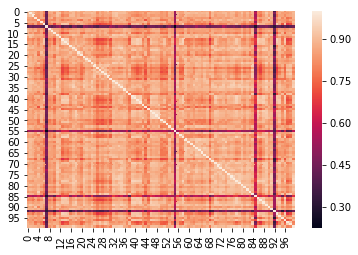

In [128]:
sns.heatmap(similarity_matrix[:100,:100])